# This GAN model is the one responsible for creating the data for the project

## Imports and config

In [30]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import cv2
from tensorflow.keras import backend

In [31]:
backend.clear_session()

In [32]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
%matplotlib inline

## Data loading

### Dataset folder definition

In [33]:
directory='/home/db/Desktop/corecode/final_data/artwork/ready_2_use/van/'
picasso_data= '/home/db/Desktop/corecode/final_data/saved_data/picasso_gray_128.npy'
warhol = '/home/db/Desktop/corecode/final_data/saved_data/warhol_128.npy'
van = '/home/db/Desktop/corecode/final_data/saved_data/van_gogh_128.npy'
dali = '/home/db/Desktop/corecode/final_data/saved_data/dali_128.npy'
scenery= '/home/db/Desktop/corecode/final_data/artwork/ready_2_use/scenery'
all_data = '/home/db/Desktop/corecode/final_data/saved_data/all_data_gray_128.npy'
impressionism_128 = '/home/db/Desktop/corecode/final_data/saved_data/impressionism_128.npy'
impressionism_256 = '/home/db/Desktop/corecode/final_data/saved_data/impressionism_256.npy'
surrealism = '/home/db/Desktop/corecode/final_data/saved_data/surrealism_128.npy'
picasso = '/home/db/Desktop/corecode/final_data/saved_data/picasso_128.npy'
gaugin = '/home/db/Desktop/corecode/final_data/saved_data/gaugin.npy'

### NPY load - main method

In [34]:
dataset = np.load(f'{dali}')

### CV2 - images load; secondary method; deprecated

In [ ]:
directory = picasso

In [ ]:
dataset=[]
IMG_SIZE = 128
IMG_CHANNELS = 3

In [ ]:
for im in os.listdir(directory):
    img_array = cv2.imread(os.path.join(directory,im))
    new_array = cv2.resize(img_array, (IMG_SIZE,IMG_SIZE), IMG_CHANNELS,cv2.COLOR_BGR2RGB)
    dataset.append(new_array)

In [6]:
len(dataset)

311

In [22]:
dataset=np.asarray(dataset)


In [ ]:
dataset= dataset/255.0

In [7]:
print(type(dataset), dataset.shape, )


<class 'numpy.ndarray'> (311, 128, 128, 3)


### Quick check

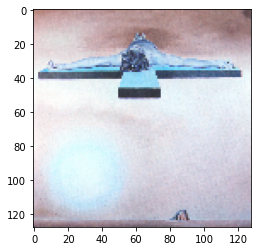

In [56]:
plt.imshow(dataset[random.randrange(0,len(dataset))])

## Define the model

In [35]:
discriminator = keras.Sequential(
    [
        keras.Input(shape=(128, 128, 3)),
        
        layers.Conv2D(32, kernel_size=3, strides=2, padding="same", input_shape=(128, 128, 3)),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.2),
        
        layers.Conv2D(64, kernel_size=3, strides=2, padding="same"),         
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.2),
                      
        layers.Conv2D(128, kernel_size=3, strides=2, padding="same"),        
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.2),
                      
        layers.Conv2D(256, kernel_size=3, strides=2, padding="same"),        
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.2),
                      
        layers.Conv2D(512, kernel_size=3, strides=2, padding="same"),        
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.2),
                      
        layers.Flatten(),
        layers.Dense(1, activation="sigmoid")
                      ],
    name="discriminator",
)
discriminator.summary()


Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        896       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 64, 64, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)     

In [36]:
latent_dim = 128

generator = keras.Sequential(
    [
        #keras.Input(shape=(latent_dim,)),
        layers.Dense(16 * 16 * 256, input_shape=(latent_dim,)),
        layers.Reshape((16, 16, 256)),
        layers.Conv2DTranspose(32, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        
        layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        
        layers.Conv2D(3, kernel_size=4, padding="same", activation="sigmoid"),
    ],
    name="generator",
)
generator.summary()


Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 65536)             8454144   
_________________________________________________________________
reshape (Reshape)            (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 32, 32, 32)        131104    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 64, 64, 64)        32832     
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 128, 128, 128)     13

In [37]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels)) # 0.05

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1)) #try with a 0.9

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

In [38]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()      
        for i in range(self.num_img):
            img = keras.preprocessing.image.array_to_img(generated_images[i])
            img.save(f"../../final_data/generated_images/generated_img_{epoch}_{i}.png") #(epoch, i))



## Train the model

In [39]:
epochs = 10

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim,)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001), #0.0001
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001), #0.0001
    loss_fn=keras.losses.BinaryCrossentropy(),
    
)



Model load - for demo

In [28]:
gan.generator.load_weights('trained_models/generator.h5')
gan.discriminator.load_weights('trained_models/discriminator.h5')

In [29]:
gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=1, latent_dim=latent_dim)]
)

Epoch 1/15
5/5 [==============================] - 4s 613ms/step - d_loss: 21260.6211 - g_loss: 24416.4316
Epoch 2/15
5/5 [==============================] - 3s 609ms/step - d_loss: 21246.0977 - g_loss: 24156.8477
Epoch 3/15
5/5 [==============================] - 3s 607ms/step - d_loss: 21322.8770 - g_loss: 24299.6875
Epoch 4/15
5/5 [==============================] - 3s 608ms/step - d_loss: 20945.7832 - g_loss: 23606.1992
Epoch 5/15
5/5 [==============================] - 3s 607ms/step - d_loss: 20851.8047 - g_loss: 22889.0586
Epoch 6/15
5/5 [==============================] - 3s 610ms/step - d_loss: 20825.7168 - g_loss: 23000.3164
Epoch 7/15
5/5 [==============================] - 3s 614ms/step - d_loss: 20479.8438 - g_loss: 23596.9531
Epoch 8/15
5/5 [==============================] - 3s 622ms/step - d_loss: 20650.9746 - g_loss: 22913.9648
Epoch 9/15
5/5 [==============================] - 3s 608ms/step - d_loss: 20316.8555 - g_loss: 22011.5215
Epoch 10/15
5/5 [=============================

______________________________________________________________________________________________________________________________________

Model save

In [24]:
gan.generator.save('trained_models/gen_v4.h5',overwrite=True)
gan.discriminator.save('trained_models/dis_v4.h5',overwrite=True)

______________________________________________________________________________________________________________________________________

Model load

In [39]:
gan.generator.load_weights('trained_models/generator.h5')
gan.discriminator.load_weights('trained_models/discriminator.h5')

### This serves to save various models at different stages of the training

In [40]:
gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=1, latent_dim=latent_dim)]
)

Epoch 1/10
5/5 [==============================] - 2s 271ms/step - d_loss: 0.6881 - g_loss: 0.7097
Epoch 2/10
5/5 [==============================] - 1s 274ms/step - d_loss: 0.6736 - g_loss: 0.7253
Epoch 3/10
5/5 [==============================] - 1s 274ms/step - d_loss: 0.6546 - g_loss: 0.7486
Epoch 4/10
5/5 [==============================] - 1s 270ms/step - d_loss: 0.6170 - g_loss: 0.7809
Epoch 5/10
5/5 [==============================] - 1s 277ms/step - d_loss: 0.5550 - g_loss: 0.8897
Epoch 6/10
5/5 [==============================] - 1s 274ms/step - d_loss: 0.4730 - g_loss: 1.0340
Epoch 7/10
5/5 [==============================] - 1s 271ms/step - d_loss: 0.3828 - g_loss: 1.3324
Epoch 8/10
5/5 [==============================] - 1s 281ms/step - d_loss: 0.3736 - g_loss: 1.4624
Epoch 9/10
5/5 [==============================] - 1s 273ms/step - d_loss: 0.3472 - g_loss: 1.4483
Epoch 10/10
5/5 [==============================] - 1s 270ms/step - d_loss: 0.3801 - g_loss: 1.4337


In [41]:
gan.generator.save('trained_models/gen_1.h5',overwrite=True)
gan.discriminator.save('trained_models/dis_1.h5',overwrite=True)

In [42]:
gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=1, latent_dim=latent_dim)]
)

Epoch 1/10
5/5 [==============================] - 1s 270ms/step - d_loss: 0.5338 - g_loss: 1.1965
Epoch 2/10
5/5 [==============================] - 1s 277ms/step - d_loss: 0.5139 - g_loss: 1.3199
Epoch 3/10
5/5 [==============================] - 1s 273ms/step - d_loss: 0.2958 - g_loss: 1.9372
Epoch 4/10
5/5 [==============================] - 1s 271ms/step - d_loss: 0.2643 - g_loss: 2.8130
Epoch 5/10
5/5 [==============================] - 1s 279ms/step - d_loss: 0.3167 - g_loss: 3.4696
Epoch 6/10
5/5 [==============================] - 1s 283ms/step - d_loss: 0.2895 - g_loss: 3.2091
Epoch 7/10
5/5 [==============================] - 1s 280ms/step - d_loss: 0.2852 - g_loss: 2.6795
Epoch 8/10
5/5 [==============================] - 1s 277ms/step - d_loss: 0.3262 - g_loss: 2.9156
Epoch 9/10
5/5 [==============================] - 1s 272ms/step - d_loss: 0.2999 - g_loss: 2.4702
Epoch 10/10
5/5 [==============================] - 1s 274ms/step - d_loss: 0.4107 - g_loss: 1.8862


In [43]:
gan.generator.save('trained_models/gen_2.h5',overwrite=True)
gan.discriminator.save('trained_models/dis_2.h5',overwrite=True)

In [44]:
gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=1, latent_dim=latent_dim)]
)

Epoch 1/10
5/5 [==============================] - 1s 279ms/step - d_loss: 0.3480 - g_loss: 1.8525
Epoch 2/10
5/5 [==============================] - 1s 278ms/step - d_loss: 0.2937 - g_loss: 2.3871
Epoch 3/10
5/5 [==============================] - 1s 281ms/step - d_loss: 0.2475 - g_loss: 3.1445
Epoch 4/10
5/5 [==============================] - 1s 281ms/step - d_loss: 0.2391 - g_loss: 2.9490
Epoch 5/10
5/5 [==============================] - 1s 282ms/step - d_loss: 0.2580 - g_loss: 2.6768
Epoch 6/10
5/5 [==============================] - 1s 280ms/step - d_loss: 0.4320 - g_loss: 1.7328
Epoch 7/10
5/5 [==============================] - 1s 279ms/step - d_loss: 0.4661 - g_loss: 1.5608
Epoch 8/10
5/5 [==============================] - 1s 276ms/step - d_loss: 0.3229 - g_loss: 2.2374
Epoch 9/10
5/5 [==============================] - 1s 279ms/step - d_loss: 0.3032 - g_loss: 3.6805
Epoch 10/10
5/5 [==============================] - 1s 281ms/step - d_loss: 0.4258 - g_loss: 3.2925


In [45]:
gan.generator.save('trained_models/gen_3.h5',overwrite=True)
gan.discriminator.save('trained_models/dis_3.h5',overwrite=True)

In [46]:
gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=1, latent_dim=latent_dim)]
)

Epoch 1/10
5/5 [==============================] - 1s 289ms/step - d_loss: 0.6018 - g_loss: 2.6816
Epoch 2/10
5/5 [==============================] - 1s 287ms/step - d_loss: 0.8290 - g_loss: 1.6334
Epoch 3/10
5/5 [==============================] - 1s 285ms/step - d_loss: 0.7598 - g_loss: 1.4918
Epoch 4/10
5/5 [==============================] - 1s 292ms/step - d_loss: 0.8152 - g_loss: 1.6863
Epoch 5/10
5/5 [==============================] - 1s 290ms/step - d_loss: 0.7849 - g_loss: 1.5490
Epoch 6/10
5/5 [==============================] - 1s 284ms/step - d_loss: 0.8495 - g_loss: 1.5213
Epoch 7/10
5/5 [==============================] - 1s 284ms/step - d_loss: 0.7378 - g_loss: 1.2862
Epoch 8/10
5/5 [==============================] - 1s 287ms/step - d_loss: 0.7595 - g_loss: 0.9944
Epoch 9/10
5/5 [==============================] - 1s 287ms/step - d_loss: 0.6861 - g_loss: 1.0181
Epoch 10/10
5/5 [==============================] - 1s 284ms/step - d_loss: 0.6078 - g_loss: 1.0369


In [47]:
gan.generator.save('trained_models/gen_4.h5',overwrite=True)
gan.discriminator.save('trained_models/dis_4.h5',overwrite=True)